# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space'] #Categories to fetch from data
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
def Q1(num_examples=5):
    ### STUDENT START ###
        
    #Print the first examples in the train_data
    
    for i in range(num_examples):
        print("======================= START Example {} for CATEGORY: {} ====".format(i+1,newsgroups_train.target_names[train_labels[i]]))
        print(train_data[i])
        print("---------------------END EXAMPLE {} for CATEGORY: {} ------\n".format(i+1,newsgroups_train.target_names[train_labels[i]]))
            
    ### STUDENT END ###

Q1(5)

======================= START Example 1 for CATEGORY: comp.graphics ====
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
---------------------END EXAMPLE 1 for CATEGORY: comp.graphics ------

======================= START Example 2 for CATEGORY: talk.religion.misc ====


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, child

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [8]:
def Q2():
    ### STUDENT START ###
    
    #1 Transform the training data into a matrix of word unigram feature vectors.
    
    #Intialize CountVectorizer, and fit_tranform for train_data
    cv1 = CountVectorizer()
    vtrain = cv1.fit_transform(train_data)
    print("Question 1: Transform the training data into a matrix of word unigram feature vectors")
    print("1.A Vocabulary size: ", vtrain.shape[1])
    print("1.B Average number of non-zero components per example: ",vtrain.nnz / float(vtrain.shape[0]))
    print("1.C. Fraction of the non-zero entries in the matrix: ",vtrain.nnz / (float(vtrain.shape[0])*float(vtrain.shape[1])))
    print("1.D. The 0th feature string is: '{}', and last feature strings is :'{}'".format(cv1.get_feature_names()[0],\
          cv1.get_feature_names()[len(cv1.get_feature_names())-1]))
    
    # 2 Now transform the training data into a matrix of word unigram feature 
    #   vectors restricting to the vocabulary with these 4 words
    
    #Reduced vocabulary to be used with CountVectorizer
    vocabulary = ["atheism", "graphics", "space", "religion"]
    
    #Create CountVectorizer with reduced vocabulary and transform traind_data
    cv2 = CountVectorizer(vocabulary=vocabulary)
    vtrain2=cv2.fit_transform(train_data)
    
    print("\nQuestion 2: transform the training data into a matrix of word unigram feature vectors restricting the vocabulary")
    print("Vocabulary size: ",vtrain2.shape[1])
    print("Vocabulary: ", cv2.vocabulary_)
    print("2.A. Average number of non-zero components per example: ",vtrain2.nnz / float(vtrain2.shape[0]))
    
    # 3 Now transform the training data into a matrix of character bigram and trigram feature vectors
    
    #Transform data into a matrix of bigram feature vectors
    cv3_bc = CountVectorizer(ngram_range=(2,2),analyzer='char')
    vtrain_bc = cv3_bc.fit_transform(train_data)
    
    print("\nQuestion 3: Now transform the training data into a matrix of character bigram and trigram feature vectors")
    print("3.A Vocabulary size for matrix of character bigram: ",vtrain_bc.shape[1])
    
    #Transform data into a matrix of trigram feature vectors
    cv3_tc = CountVectorizer(ngram_range=(3,3),analyzer='char')
    vtrain_tc = cv3_tc.fit_transform(train_data)
    print("3.A Vocabulary size for matrix of character trigram: ",vtrain_tc.shape[1])
    
    # 4 Now transform the training data into a matrix of word unigram feature vectors and prune words 
    #   that appear in fewer than 10 documents.

    #min_df = 10, ignore terms that appears in less than 10 documents 
    cv4 = CountVectorizer(ngram_range=(1,1), min_df=10)
    vtrain4 = cv4.fit_transform(train_data)

    print("\nQuestion 4:")
    print("4.A. Vocabulary size when pruning words min_df =10 : ",vtrain4.shape[1])
    
    # 5 Now again transform the training data into a matrix of word unigram feature vectors.
    # A. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
    
    print("\nQuestion 5:")
    
    #Fit_transform CountVectorizer to Train Data
    cv5_train = CountVectorizer()
    vtrain5 = cv5_train.fit_transform(train_data)

    #Fit_transform CountVectorizer to Dev Data
    cv5_dev = CountVectorizer()
    vdev5 = cv5_dev.fit_transform(dev_data)
    
    #Get the words included in vocabulary for deve data and train data
    dev_voc = set(cv5_dev.vocabulary_.keys())
    tra_voc = set(cv5_train.vocabulary_.keys())
    
    #dif_voc = dev_voc.difference(tra_voc)    
    #print("5.A. Proportion of words in dev vocabulary missing in train vocabulary is: ",len(dif_voc)/ vtrain5.shape[1])
    
    ratio = (1.0 *len(dev_voc) - len(tra_voc.intersection(dev_voc))) / len(dev_voc)
    print("5.A. Fraction of dev vocabulary missing from train vocabulary is: ", ratio)
  
    ### STUDENT END ###

Q2()

Question 1: Transform the training data into a matrix of word unigram feature vectors
1.A Vocabulary size:  26879
1.B Average number of non-zero components per example:  96.70599803343165
1.C. Fraction of the non-zero entries in the matrix:  0.0035978272269590263
1.D. The 0th feature string is: '00', and last feature strings is :'zyxel'

Question 2: transform the training data into a matrix of word unigram feature vectors restricting the vocabulary
Vocabulary size:  4
Vocabulary:  {'atheism': 0, 'graphics': 1, 'space': 2, 'religion': 3}
2.A. Average number of non-zero components per example:  0.26843657817109146

Question 3: Now transform the training data into a matrix of character bigram and trigram feature vectors
3.A Vocabulary size for matrix of character bigram:  3291
3.A Vocabulary size for matrix of character trigram:  32187

Question 4:
4.A. Vocabulary size when pruning words min_df =10 :  3064

Question 5:
5.A. Fraction of dev vocabulary missing from train vocabulary is:  0.2

### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [9]:
def KNN_text2(k, train_data, train_labels, dev_data, dev_labels):
    
    #Test KNN Model function including a pipeline
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # We can use Pipeline to add vectorizer -> transformer -> classifier all in a one compound classifier
    text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', knn),
    ])
    
    # Fitting our train data to the pipeline
    text_clf.fit(train_data, train_labels)
    
    # Predicting our test data
    print(text_clf.score(dev_data, dev_labels))
    print(metrics.f1_score(dev_labels, text_clf.predict(dev_data), average="weighted"))



In [10]:
KNN_text2(1, train_data, train_labels, dev_data, dev_labels)

0.3505917159763314
0.24338329154576988


In [11]:
def KNN_text1(k, train_data, train_labels, dev_data, dev_labels):
    
    #Helper function to create and fit KNN model. Return f1_score

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data, train_labels)
        
    return([model.score(dev_data,dev_labels), metrics.f1_score(dev_labels, model.predict(dev_data), average="weighted")])

In [12]:
def MNB_text1(alpha, train_data, train_labels, dev_data, dev_labels):
    
    #Helper function to create and fit MNB model. Return f1 score.
    
    clf2 = MultinomialNB(alpha=alpha)
    clf2.fit(train_data, train_labels)
    return([clf2.score(dev_data, dev_labels), metrics.f1_score(dev_labels, clf2.predict(dev_data), average="weighted")])

In [17]:
def Q3():
    ### STUDENT START ###
    
    #Transform the training and development data to matrices of word unigram feature vectors.
    cv1 = CountVectorizer()
    vtrain = cv1.fit_transform(train_data)
    vdev = cv1.transform(dev_data)
 
    # QUESTION 1: transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
    # Not used in the function- just for testing
    tfidf_transformer = TfidfTransformer()
    vtrain_tfidf = tfidf_transformer.fit_transform(vtrain)
    vdev_tfidf = tfidf_transformer.transform(vdev)

    #Q2. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score. 
    #   For each model, show the k value and f1 score.
    
    #List to store accuracy scores for models
    accuracy = []
    f1_knn = []
    n_models = 10
    
    #Loop to create KNN models & store accuracy metric
    for k in range(1,n_models+1,1):
        mod_knn = KNeighborsClassifier(n_neighbors=k)
        mod_knn.fit(vtrain, train_labels)
        f1_knn.append(metrics.f1_score(dev_labels, mod_knn.predict(vdev), average="weighted"))
        
    #Create Dataframe with key statistics for each KNN model
    df_KN_accuracy = pd.DataFrame({"K": range(1,n_models+1,1), "F1": f1_knn})
    print("QUESTION 2 - F1_Score for K-Nearest Neighbor Models: Best performance is for K=7")
    print(df_KN_accuracy)
    
    #3 Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set 
    #  approximately to optimize f1 score. For each model, show the alpha value and f1 score.

    #List to store accuracy scores for models
    f1_mnb = []
    alpha_list_MNB = [0.009, 0.01, 0.05, 0.051, 0.06, 0.065, 0.067, 0.070, 0.071, 0.072, 0.1, 0.12, 0.2]
    
    #Loop to create MNB models & store accuracy metric
    for alpha in alpha_list_MNB:
        mnb = MultinomialNB(alpha=alpha)
        mnb.fit(vtrain, train_labels)
        f1_mnb.append(metrics.f1_score(dev_labels, mnb.predict(vdev), average="weighted"))
        
    #Create Dataframe with key statistics for each model
    df_MNB_accuracy = pd.DataFrame({"alpha": alpha_list_MNB, "F1":f1_mnb})
    print("\nQUESTION 3 - F1_Score for MNB Models - Best Performance for apha=0.1:")
    print(df_MNB_accuracy)
    
    # 4 Produce several Logistic Regression models by varying L2 regularization strength (C), 
    #   including one with C set approximately to optimize f1 score. For each model, show the C value, f1 score, 
    #   and sum of squared weights for each topic.
    
    f1_lr1 = []
    c_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    topic_weights = np.empty((0,len(newsgroups_train.target_names)))
    print(topic_weights.shape)

    #Run logistic regression for different c-values
    for c in c_list:
        clf = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l2', max_iter=200)
        
        #Fitting and get f1 score
        clf.fit(vtrain, train_labels)
        f1_lr1.append(metrics.f1_score(dev_labels, clf.predict(vdev), average="weighted"))
        
        #Get the Sum of square for coefficients for every topic
        tw = (clf.coef_**2).sum(1)
        topic_weights = np.r_[topic_weights,[np.array(tw)]]
    
    #Create Dataframe with key statistics for each model
    df_lr1_accuracy = pd.DataFrame({"C": c_list, "F1":f1_lr1})
    i = 0
    for topic in newsgroups_train.target_names:
        df_lr1_accuracy[topic] = topic_weights[:,i]
        i += 1

    print("\nQUESTION 4 - Information for LogisticRegression Models - Best Performance for c=0.3:")
    print(df_lr1_accuracy)
    
    return(clf.coef_)

    
    ### STUDENT END ###

cf = Q3()

QUESTION 2 - F1_Score for K-Nearest Neighbor Models: Best performance is for K=7
    K        F1
0   1  0.380503
1   2  0.380542
2   3  0.408415
3   4  0.403123
4   5  0.428761
5   6  0.446665
6   7  0.450479
7   8  0.446984
8   9  0.436567
9  10  0.427850

QUESTION 3 - F1_Score for MNB Models - Best Performance for apha=0.1:
    alpha        F1
0   0.009  0.775166
1   0.010  0.775166
2   0.050  0.785856
3   0.051  0.785856
4   0.060  0.786201
5   0.065  0.786315
6   0.067  0.786315
7   0.070  0.786315
8   0.071  0.786315
9   0.072  0.786315
10  0.100  0.790305
11  0.120  0.788547
12  0.200  0.787630
(0, 4)

QUESTION 4 - Information for LogisticRegression Models - Best Performance for c=0.3:
       C        F1  alt.atheism  comp.graphics   sci.space  talk.religion.misc
0    0.1  0.696624    27.132532      24.659058   27.459563           23.019894
1    0.2  0.705873    49.734153      42.748634   49.331967           42.660496
2    0.3  0.710085    69.293418      57.888797   67.906267    

**ANSWER:**  
**5. Why doesn't k-Nearest Neighbors work well for this problem?**  
This is due to what is known as the curse of the dimensionality.  The kNN classifier assumes that similar points share similar labels. However, this assumptions is broken in high dimensional spaces.  Thus, points that are drawn from a probability distribution with multiple dimensions, tend to never (unlikely to be) be close together when there are too many dimensions.  The following figures illustrate how the distance increases as the number of dimensions increase.

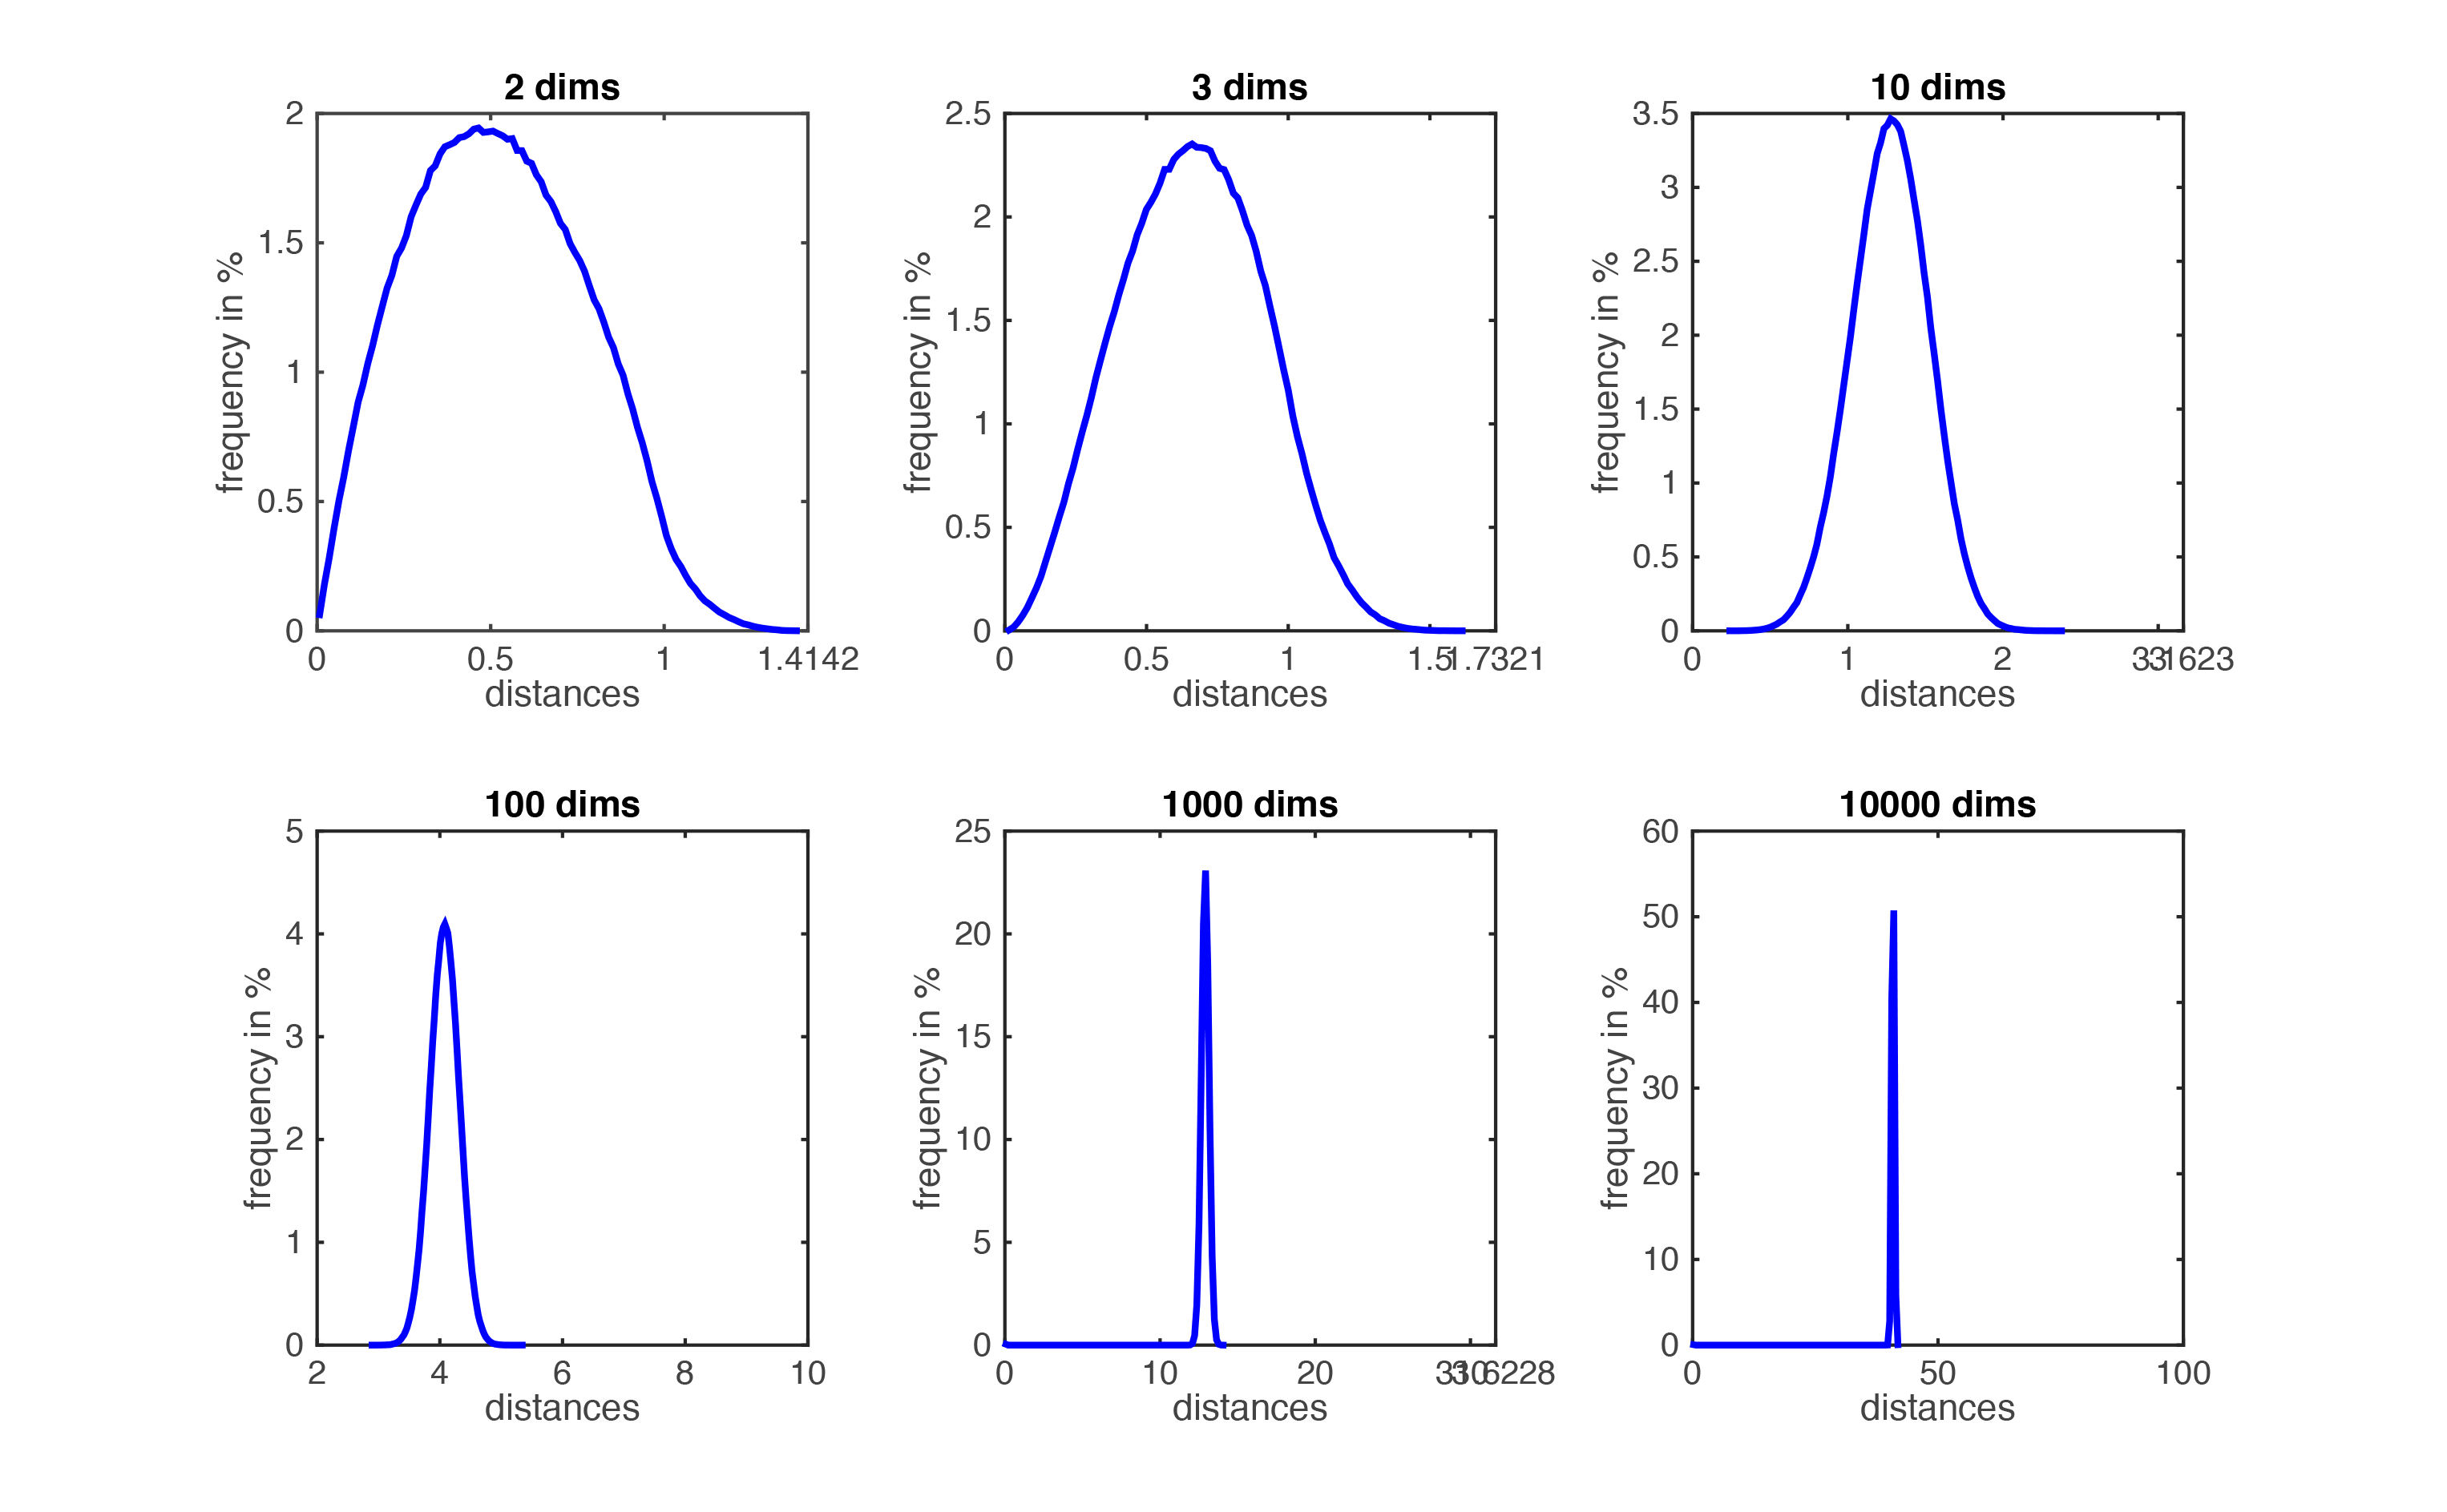

Taken from: https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html

**6. Why doesn't Logistic Regression work as well as Naive Bayes does?**  (Outliers? Linear?)  
The performance of logistic regression versus Naive Bayes can't be generalized.  There would be situations where Logistic Regression performs better than Naive Bayes and viceversa (as in this case).  This result is likely to be related to this specific dataset.  One hypothesis is that the logistic regression models are sensitive to outliers, and there may be certain instances that are pulling logistic regression model away from the correct prediction. 

**7. What is the relationship between logistic regression's sum of squared weights vs. C value?**  

In regulization, c is equal to 1 /𝝺.  𝝺 is known as Regularization parameter.  In the loss function (shown below for l2 regulization), if lambda is extremely large, it leads to adding huge weights to the loss function (to Erro(Y,Y_hat), and leads to underfitting.  In other words, the larger the number of parameters (represented by weights), the higher the penalty to the loss function when 𝝺 is large (c is low). Thus, the higher the c, the lower the 𝝺, and the lower the penalty to the loss function.  The following equation presents the loss function and the error function. 

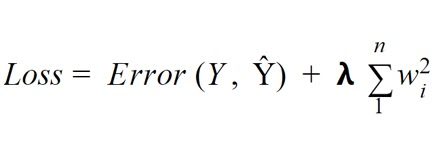

Image taken from:
https://www.analyticssteps.com/blogs/l2-and-l1-regularization-machine-learning

Where the following function represents the error:
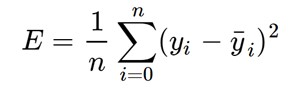

Regularization generally refers the concept that there should be a complexity penalty for more extreme parameters. The idea is that just looking at the training data and not paying attention to how extreme one's parameters are leads to overfitting. A high value of C tells the model to give high weight to the training data, and a lower weight to the complexity penalty. A low value tells the model to give more weight to this complexity penalty at the expense of fitting to the training data. Basically, a high C means "Trust this training data a lot", while a low value says "This data may not be fully representative of the real world data, so if it's telling you to make a parameter really large, don't listen to it".

**Note:** Rather than specifying λ, you specify C=1/λ.  

**Other references:**  
https://stackoverflow.com/questions/22851316/what-is-the-inverse-of-regularization-strength-in-logistic-regression-how-shoul
https://stackoverflow.com/questions/67513075/what-is-c-parameter-in-sklearn-logistic-regression

### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [18]:
def get_features(coefL, vocabulary, num_features):
    
    #Initialize list to store the name of the top feature and the coefficent for the top feature
    feature_list = []
    coef_list = []
    
    #For the number of top features (5), find the highest ranked, store the name, and the coefficient

    top = sorted(range(len(coefL)), key=lambda i: coefL[i], reverse=True)[:num_features]

    for ind in top:
        feature_list.append(str(vocabulary[ind]))
        coef_list.append(float(coefL[ind]))
    
#Previous version - kept for sanity check on values    
#     for i in range(num_features):
#         m = max(coefL)
#         pos_max = np.where(coefL == m)
#         feature_list.append(str(vocabulary[pos_max[0]][0]))
#         coef_list.append(float(coefL[pos_max[0]]))
#         coefL = np.delete(coefL, pos_max)
#         vocabulary = np.delete(vocabulary, pos_max)
        
    return(feature_list, coef_list)

In [19]:
def find_tp(vocabul, top_features, coeficients, topics):
    
    #Find the indexes for the top_features in vocabulary
    mask1 = [vocabul[e] for e in top_features]
    
    #Create an empty dataframe to store information
    df = pd.DataFrame()
    
    #Store the top features in dataframe
    df["Top_Features"] = top_features
    
    #For each topic, get the coeficients and add them to data frame
    i = 0
    for topic in topics:
        df[topic] = coeficients[i][mask1]
        i += 1
    
    return(df)

In [20]:
def Q4():
    ### STUDENT START ###
    
    #Transform the training and development data to matrices of word unigram feature vectors.
    
    #cv1 = CountVectorizer(ngram_range=(2,2),analyzer='char')
    cv1 = CountVectorizer(ngram_range=(2,2))
    vtrain = cv1.fit_transform(train_data)
    vdev = cv1.transform(dev_data)
    
    #Create and fit logistic regression model
    lr_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto", penalty='l2', max_iter=200)
    lr_model.fit(vtrain, train_labels)

    #Initialize lists to store top coefficients (tw), and top features (tf)
    tw = []
    tf = []
    
    #Set to include only the unique featrues across the four topics.
    f_set = set()
    
    print("Q4-2 For each topic, find the 5 features with the largest weights (not absolute value).") 
    print("     if there are no overlaps, you can expect 20 features in total.\n")
    
    #For each topic, find the top 5 features (words), and their coefficients.
    for i in range(lr_model.coef_.shape[0]):
        top_features, feat_coefs = get_features(lr_model.coef_[i], np.array(cv1.get_feature_names()), 5)
        tw.append(feat_coefs)
        tf.append(top_features)
        f_set = f_set.union(top_features)
        print("Top Features for - TOPIC: ",i, newsgroups_train.target_names[i])
        print(top_features)
        print(feat_coefs)
    
    f_set = list(f_set)
    
    df_tf = find_tp(cv1.vocabulary_, f_set, lr_model.coef_, newsgroups_train.target_names)
    
    print("\nQ4-3 Show a 20 row (features) x 4 column (topics) table of the weights.") 
    print("     So, for each of the features (words) found, we show their weight for all topics.\n") 

    print(df_tf)
    df_tf.to_csv("q4_to_topics_CEM.csv")
    
    ### STUDENT END ###

Q4()

Q4-2 For each topic, find the 5 features with the largest weights (not absolute value).
     if there are no overlaps, you can expect 20 features in total.

Top Features for - TOPIC:  0 alt.atheism
['claim that', 'cheers kent', 'was just', 'you are', 'are you']
[0.6055486621081527, 0.5557195069012678, 0.4820504047877665, 0.47274051956737395, 0.44695345762586736]
Top Features for - TOPIC:  1 comp.graphics
['looking for', 'in advance', 'comp graphics', 'out there', 'is there']
[1.1083689182414485, 0.8325683896327035, 0.8011997918549649, 0.7586612214364076, 0.7550095212137894]
Top Features for - TOPIC:  2 sci.space
['the space', 'the moon', 'sci space', 'and such', 'it was']
[0.8710455478402809, 0.8309666284498309, 0.6210354486069872, 0.5904946716767778, 0.525374874603278]
Top Features for - TOPIC:  3 talk.religion.misc
['the fbi', 'cheers kent', 'ignorance is', 'but he', 'of jesus']
[0.5519971121514877, 0.5348117984034478, 0.5043053522563352, 0.4918714704021989, 0.42375736938369063]

Q4-

**ANSWER:**  
**4. Do you see any surprising features in this table?**  
- Many of the top features are stop word or commonly used words such as "it was", "you are", "but he", which could be related to any topic.
- "cheers kent" is important for both atheism and religion. It seems to be a salutation expression.
- interesting to see "the fbi" as a top feature for religion.

**Note:** The above table include only 19 features, as one feature is in the top five for two topics.  The table below shows the original table with the duplicate feature, where "cheers kent" is in the top five in "alt.atheism" and "talk.religion.misc".

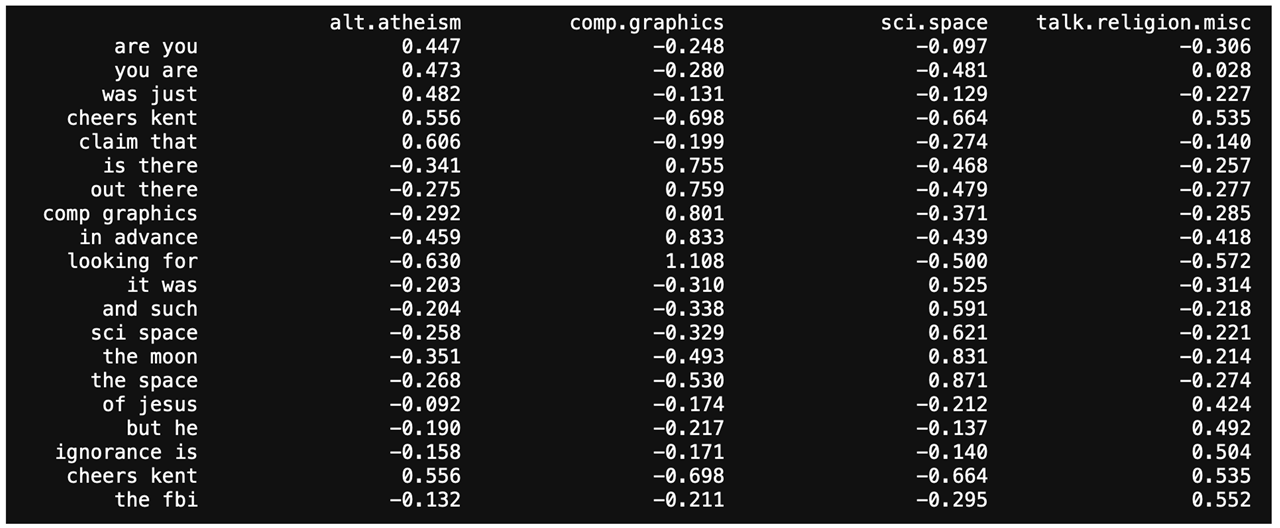

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [21]:
def IdentityPreProcess(s):
    return s

In [22]:
def preprocess1(s):
    s = s.lower()
    s = re.sub('\d+', 'NUM', s)                  #Replace any digig (one or more occurrences) with word "NUM"
    s = re.sub('[^(a-zNUM)]', ' ',s)             #Replace any sequence that starts with letters and NUM with " "
    s = ' '.join([x[:5] for x in s.split()])     #Split s and join only the first 5 characters of each word
    return(s)

In [36]:
def preprocess2(s):
    s = s.lower()
    s = re.sub('\d+', 'XXX', s)                   #Replace any digig (one or more occurrences) with word "NUM"
    s = re.sub('[^(a-zXXX)]', ' ',s)              #Replace any sequence that starts with letters and NUM with " "

    s = s.replace(",","").replace(".","")
    
    s = ' '.join([x[:5] for x in s.split()])      #Split s and join only the first 5 characters of each word
    s = ' '.join( [w for w in s.split() if len(w)>1] )  #Take out any word that is length is 1
    s = ' '.join( [w for w in s.split() if w!='to'] )   #Take out the word to
    s = ' '.join( [w for w in s.split() if w!='at'] )   #Take out the word at
    s = ' '.join( [w for w in s.split() if w!='be'] )   #Take out the word be
    s = ' '.join( [w for w in s.split() if w!='is'] )   #Take out the word is
    s = ' '.join( [w for w in s.split() if w!='are'] )   #Take out the word are
    s = ' '.join( [w for w in s.split() if w!='we'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='it'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='was'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='there'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='were'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='just'] )   #Take out the word are
#     s = ' '.join( [w for w in s.split() if w!='that'] )   #Take out the word are
    
    return(s)

In [37]:
def Q5():
    ### STUDENT START ###
    
    #Initialize List to store information about the models
    question_list = []
    model_name =[]
    model_f1_score = []
    model_voc_size = []
    
    c= 0.5
    
    #1. Logistic Regression model (wiht no preporcessing of text) - using Identity Function
    cv1 = CountVectorizer(preprocessor=IdentityPreProcess)
    vtrain = cv1.fit_transform(train_data)
    vdev = cv1.transform(dev_data)
    lr5_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l2')
        
    #Fitting and getting f1
    lr5_model.fit(vtrain, train_labels)
    f1 = metrics.f1_score(dev_labels, lr5_model.predict(vdev), average="weighted")
    
    #Update list with information for the model to be presented in summary dataframe
    question_list.append("Q1. Logist Regress No Preprocessing")
    model_name.append("LR-No preprocessing")
    model_f1_score.append(f1)
    model_voc_size.append(vtrain.shape[1])
    
    #2. Produce an improved Logistic Regression model by preprocessing the text. 
    #   Evaluate and show its f1 score and size of the vocabulary. Aim for an improvement in f1 score of 0.02.

    cv2 = CountVectorizer(preprocessor=preprocess1)
    vtrain2 = cv2.fit_transform(train_data)
    vdev2 = cv2.transform(dev_data)
    lr52_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l2')
    
    #Fitting and getting f1
    lr52_model.fit(vtrain2, train_labels)
    f1 = metrics.f1_score(dev_labels, lr52_model.predict(vdev2), average="weighted")
    
    #Update list with inforamtion for the model to be presented in summary dataframe
    question_list.append("Q2a. Logist Regress with Preprocessing One")    
    model_name.append("LR-preprocessing 1")
    model_f1_score.append(f1)
    model_voc_size.append(vtrain2.shape[1])
    
    #2.1 Testing other pre-processing approaches
    cv3 = CountVectorizer(preprocessor=preprocess2)
    vtrain3 = cv3.fit_transform(train_data)
    vdev3 = cv3.transform(dev_data)    
    lr53_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l2')
    
    #Fitting and getting f1
    lr53_model.fit(vtrain3, train_labels)
    f1 = metrics.f1_score(dev_labels, lr53_model.predict(vdev3), average="weighted")
    
    #Update list with inforamtion for the model to be presented in summary dataframe
    question_list.append("Q2b. Logist Regress with Preprocessing Two")    
    model_name.append("LR-preprocessing 2")
    model_f1_score.append(f1)
    model_voc_size.append(vtrain3.shape[1])

    
    #Create Summary DataFrame and Print Results
    df_summary = pd.DataFrame({"Question": question_list,
                               #"LR Model": model_name,
                               "F1 Score": model_f1_score,
                               "Vocabulary Size": model_voc_size})
    print("Q1-2: Table presenting F1_score for model without pre-processing, and two additional pre-processing")
    print(df_summary)


    ### STUDENT END ###

Q5()

Q1-2: Table presenting F1_score for model without pre-processing, and two additional pre-processing
                                     Question  F1 Score  Vocabulary Size
0         Q1. Logist Regress No Preprocessing  0.706911            33291
1  Q2a. Logist Regress with Preprocessing One  0.725979            15046
2  Q2b. Logist Regress with Preprocessing Two  0.736203            15046


**ANSWER:**  
**How much did the improved model reduce the vocabulary size?**  
The model without pre-processing had an F1 score of 0.706911, with a vocabulary size of 33291.  I generated two types of models with additional preprocessing, and the results are as follows:
- Using preprocessing 1 (replacing numbers with NUM, and including the first 5 letters of each word): F1-score went up to 0.725979 , and the vocabulary size went down to 15046.
- Using preprocessin 2 (apply preprocessing 1, and taking out "to", "at", "be", "is", "are", "we"): F1-score went up to 0.736203, and the vocabulary size was also 15046.


### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

In [38]:
def red_voca2(vectorizer, lr):
    #keep features that have at least 1 non-zero weight.
    indices_to_keep = []
    for i, feature_sum in enumerate((lr.coef_ !=0).sum(0)):
        if feature_sum > 0: indices_to_keep.append(i)
            
    #Create a vocabulary dict from the features indices.
    names_map = vectorizer.get_feature_names()
    vocab_list = [names_map[i] for i in indices_to_keep]
    vocabulary = dict((k,v) for (v,k) in enumerate(vocab_list))
    
    return(vocab_list, vocabulary)

In [39]:
def red_voca(vocabulary, coefficients, topics):
    
    set_zeros = set()
    
    for i in range(len(topics)):
        set_temp = np.where(coefficients[i]!=0)
        set_tem = set(set_temp[0])
        if len(set_zeros) == 0:
            set_zeros = set_temp
        else:
            if type(set_zeros) != set:
                set_zeros = set(set_zeros[0])
            if type(set_temp) != set:
                set_temp = set(set_temp[0])
            set_zeros = set_zeros.union(set_temp)
            
    new_vocabulary = []
    for key,value in vocabulary.items():
        if value in set_zeros:
            new_vocabulary.append(key)
            
    return (new_vocabulary)

C:\Users\asi40\.conda\envs\w207\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Q1-2: Table presenting F1_score for models:
           C  Voc-L1  F1-L1 Full Voc  Voc-Red  F1 L2 (c=0.5) Red voc
0      0.001   26879        0.244928        3               0.333569
1      0.010   26879        0.422068       17               0.462206
2      0.030   26879        0.527441       68               0.609448
3      0.050   26879        0.578312      126               0.646855
4      0.100   26879        0.645700      222               0.693876
5      0.300   26879        0.697426      527               0.678183
6      0.500   26879        0.687161      751               0.671710
7      1.000   26879        0.694744     1106               0.680289
8     10.000   26879        0.655617     3439               0.690802
9     50.000   26879        0.631537     5971               0.696092
10   100.000   26879        0.623455     7723               0.700125
11  1000.000   26879        0.584941    25368               0.708214


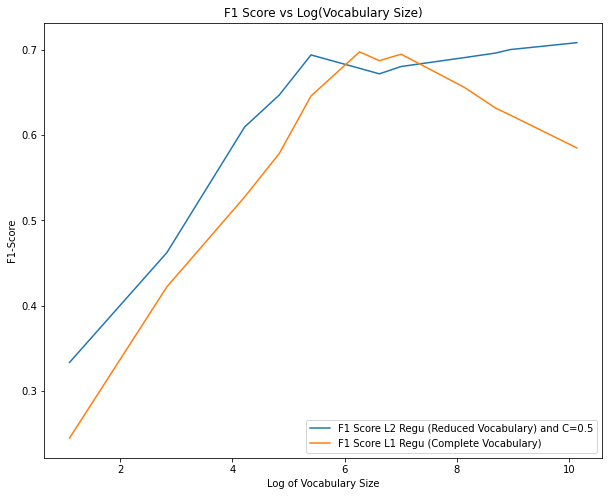

In [43]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###

    #Initialize lists to store information about the models
    model_name =[]
    model_f1_score = []
    model_voc_size = []
    model_voc_red = []
    red_voc = []
    
    model_name_l1 =[]
    model_f1_l1 = []
    model_voc_l1 = []
        
    model_name_l2 = []
    model_f1_l2 = []
    model_voc_l2 = []
    
    #1. Logistic Regression model (wiht no preporcessing of text) - using Identity Function
        
    #c_list = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
    #c_list = [0.001, 0.01, 0.03, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.1, 1.5]
    c_list = [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10, 50, 100, 1000]
    
    #For each c in the list, run LR with l1 regulization, find reduced vocabulary, and run LR with l2 regul (c=0.5)
    for c in c_list:
        #Set, fit and find F1-score for linear model with L1 regulization
        cv1 = CountVectorizer()
        vtrain = cv1.fit_transform(train_data)
        vdev = cv1.transform(dev_data)

        #Create model, fit data, and find f1 score
        lr6_1_model = LogisticRegression(C=c, solver="liblinear", penalty='l1', max_iter = 200, tol=0.015)        
        lr6_1_model.fit(vtrain, train_labels)
        f1 = metrics.f1_score(dev_labels, lr6_1_model.predict(vdev), average="weighted")
    
        #Store model information in dataframe summary
        model_name.append("LR-L1")
        model_f1_score.append(f1)
        model_voc_size.append(vtrain.shape[1])
        
        #1-A. Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
        reduced_vocabulary = red_voca(cv1.vocabulary_, lr6_1_model.coef_, newsgroups_train.target_names)
        #reduced_vocabulary, voc = red_voca2(cv1, lr6_1_model)
        model_voc_red.append(len(reduced_vocabulary))
        red_voc.append(reduced_vocabulary)
        
        cv11 = CountVectorizer(vocabulary=reduced_vocabulary)
        vtrain = cv11.fit_transform(train_data)
        vdev = cv11.transform(dev_data)

        #Set, fit and find F1-score for linear model with L2 regulization
        lr6_2_model = LogisticRegression(C=c, solver="liblinear", multi_class="auto", penalty='l1', tol=0.015)        
        lr6_2_model.fit(vtrain, train_labels)
        f1 = metrics.f1_score(dev_labels, lr6_2_model.predict(vdev), average="weighted")
   
        #Store model information in dataframe summary
        model_name_l1.append("L1-red")
        model_f1_l1.append(f1)
        model_voc_l1.append(vtrain.shape[1])

        cv2 = CountVectorizer(vocabulary=reduced_vocabulary)
        vtrain = cv2.fit_transform(train_data)
        vdev = cv2.transform(dev_data)

        #Set, fit and find F1-score for linear model with L2 regulization
        lr6_3_model = LogisticRegression(C=0.5, solver="liblinear", penalty='l2', tol=0.015)        
        lr6_3_model.fit(vtrain, train_labels)
        f1 = metrics.f1_score(dev_labels, lr6_3_model.predict(vdev), average="weighted")
   
        #Store model information in dataframe summary
        model_name_l2.append("L2-red")
        model_f1_l2.append(f1)
        model_voc_l2.append(vtrain.shape[1])

    
    #Create Summary DataFram
    df_summary = pd.DataFrame({"C": c_list,
                               "Voc-L1": model_voc_size,
                               "F1-L1 Full Voc": model_f1_score,
                               "Voc-Red": model_voc_l1,
                               #"F1_L1 Red": model_f1_l1,
                               "F1 L2 (c=0.5) Red voc": model_f1_l2})
    
    print("Q1-2: Table presenting F1_score for models:")
    print(df_summary)
    
    #F1 score vs. Log of Vocabulary Size
    fig_q6, axs_q62 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
    #axs_q62.plot(np.log(df_summary["Voc-Red"]), df_summary["F1_L1 Red"], label = 'F1 Score L1 Regu (Reduced Vocabulary)')
    axs_q62.plot(np.log(df_summary["Voc-Red"]), df_summary["F1 L2 (c=0.5) Red voc"], label = 'F1 Score L2 Regu (Reduced Vocabulary) and C=0.5')
    axs_q62.plot(np.log(df_summary["Voc-Red"]), df_summary["F1-L1 Full Voc"], label = 'F1 Score L1 Regu (Complete Vocabulary)')
    axs_q62.set_xlabel("Log of Vocabulary Size")
    axs_q62.set_ylabel("F1-Score")
    plt.title("F1 Score vs Log(Vocabulary Size)")
    axs_q62.legend()
    
    return(df_summary, red_voc)

    ### STUDENT END ###

dfs, rv = Q6()

**ANSWER:**  
**3. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?**  The above table, present the F1 score for Logistic Regression using L1 regulation (across different c values), and compared to Logistic Regression using L2 using the reduced vocabulary (c=0.1).  The L2 regulized Logistic Regression using reduced vocabulary (keeping C=0.5) has a better f1_score versus L1 regulized LR models for most c values. In the graph above, the yellow line (L2 regulated using reduced vocabulary and c=0.5) is above the LR models (l1 regulated) in most cases.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [44]:
def rratios(pred_prob, dev_label):
    
    rratios_list = []
    i = 0
    for pp in pred_prob:
        maxp = pp.max()
        max_topic = np.where(pp == maxp)
        rratios_list.append(maxp/pp[dev_label[i]])
        i += 1

    return(rratios_list)
    

In [46]:
def Q7():
    ### STUDENT START ###

    cv1 = TfidfVectorizer()
    vtrain = cv1.fit_transform(train_data)
    vdev = cv1.transform(dev_data)
    
    vtrain_model = vtrain
    vdev_model = vdev

    lr_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty='l2')
    lr_model.fit(vtrain_model, train_labels)
    predictions = lr_model.predict(vdev_model)
    
    f1 = metrics.f1_score(dev_labels, predictions, average="weighted")
    
    print("F1_score for logistic-regression model: ", f1)
    print("Weight for mormon in religious topic: ",lr_model.coef_[3][cv1.vocabulary_["mormon"]])
    
    pred_prob = lr_model.predict_proba(vdev_model)
    
    r_ratios = rratios(pred_prob, dev_labels)
    
    df_docs = pd.DataFrame()
    
    df_structure = {'Num': [],
                    'Corr_Top': [],
                    'PPr_Corrl': [],
                    'Pred_Topic':[],
                    'Max_PPr': [],
                    'R_ratio': [],
                    #'Mes_Len': []
                   }
    
    df_docs = pd.DataFrame(df_structure)
    
    top = sorted(range(len(r_ratios)), key=lambda i: r_ratios[i], reverse=True)[:3]
    print("Document Numbers with highest R-ratio: ",top)
    
    for i in top:
        new_row = {'Doc Num': i, 
                   'Corr_Top':newsgroups_train.target_names[dev_labels[i]], 
                   #'Corr_Top':dev_labels[i], 
                   'PPr_Corrl': pred_prob[i][dev_labels[i]], 
                   "Pred_Topic": newsgroups_train.target_names[predictions[i]],
                   'Max_PPr':pred_prob[i].max(), 
                   "R_ratio":r_ratios[i], 
                   #'Mes_Len':len(dev_data[i])
                  }
        
        df_docs = df_docs.append(new_row, ignore_index=True)

        print("--------------------START----------------------------------")
        print("Real Topic: ",dev_labels[i], ", Predicted topic: ",predictions[i], ",Positions: ", i)
        print("Prob Correct Topic:", pred_prob[i][dev_labels[i]], "Max Proba for Topic: ", pred_prob[i].max())
        print("R_ratio: ",r_ratios[i], ", Length of message: ",len(dev_data[i]))
        print("Number of non-zero coefficients for topic: ",np.count_nonzero(lr_model.coef_[dev_labels[i]] != 0))
        print("-----------------------------------------------------------")
        print(dev_data[i])
        print("=====================END==================================")
    
    print("\nSUMMARY TABLE:")
    print(df_docs)
    
    return(lr_model.predict_proba(vdev_model), lr_model.predict(vdev_model), f1, lr_model.coef_, cv1)

    ### STUDENT END ###

pp, p, f1, coe, cv= Q7()

F1_score for logistic-regression model:  0.7597662427853104
Weight for mormon in religious topic:  0.5469614816578652
Document Numbers with highest R-ratio:  [215, 665, 607]
--------------------START----------------------------------
Real Topic:  3 , Predicted topic:  1 ,Positions:  215
Prob Correct Topic: 0.0010692548833478894 Max Proba for Topic:  0.9937202459451938
R_ratio:  929.3576876953857 , Length of message:  2579
Number of non-zero coefficients for topic:  26879
-----------------------------------------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies 

***ANSWER:**  
**1. How is `TfidfVectorizer` different than `CountVectorizer`?**  
CountVectorizer counts the number of times a word appears in the document.  This may result in a bias in favor of most frequent words.  This approach also penalizes rare words which could be important for processing data more efficiently.

On the other hand, TfidfVectorizer considers the overall document weightage of a word.  In other words, it is normalizing the count based on the frequency of the words. It helps balancing (penalizing) most frequent words. In general, TidfVectorizer weights the word counts by a measure of how often they appear in the documents.

**2. Show the 3 documents with highest R ratio**
Above, the three documents with the highest R ratio are presented.

**3. Explain what the R ratio describes.**  
R ratio is the relationship between the probability used to classify a specific document (maximum of the predict_prob vector corresponding to the document) and the predicted probability for the correct label.  If the model was correct in classifying the document, R_ratio would be equal to one.  However, a high R ratio indicates that the model was confident in classifying a document (assigning a high probability to the predicted topic for the document), while the real label got a low probability.  In essence, R-ration indicate how far was the model in predicting the classification of the document.  The higher the R-ratio, the fardest away from the true classification..

**4. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.**  
- For the first document (215), it is clear that the main topic is about the Book of Mormon (religious).  However, the model seems to be given a lot of weight to computer related words such as Microsoft, ASCII, LaTex, and other computer related terms.  
- For the second document (665), even though the document is about the Book of Mormon (religious), the model is placing more weight to computer related words such as ftp site, online version, internet address.  Thus, it is classifying it as related to comput.graph too.
- For the third document (607 - "The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds..."), it seems that some words such as "story", "children" are leading the model to classify it as religious, and not the correct label (alt.atheism).
  
**Proposed Solution:**  
To fix the issue with the first (215) and second (665) documents, I would seek to increase the weight of "mormon" for documents related to religion.  The current weight for "mormon" for religious topic is 0.5469614816578652.  One way to do so, is to do a preprocessing of the documents, replacing the word "mormon" with several instances of "mormon".  For example,

For each word **"mormon"**, replace it with 
**"mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon".**

This will help to increase the count of the word "mormon" for documents that have it, and thus increasing its weight when classifying the document.  I will try this in preprocessing in next question (Q8).  In addition, I will try removing some stop words that are adding noise to the classification.

In [60]:
def preprocess3(s):
    
    #Preprocessing to replace the word "mormon" with several instances of the word "mormon" - to increase its weight
    s = s.lower()
    s = s.replace("mormon","mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon")

    s = re.sub('\d+', 'XXX', s)                   #Replace any digig (one or more occurrences) with word "NUM"
    s = re.sub('[^(a-zXXX)]', ' ',s)              #Replace any sequence that starts with letters and NUM with " "

    s = s.replace(",","").replace(".","")
    
    s = ' '.join([x[:5] for x in s.split()])      #Split s and join only the first 5 characters of each word
    s = ' '.join( [w for w in s.split() if len(w)>1] )  #Take out any word that is length is 1
    s = ' '.join( [w for w in s.split() if w!='to'] )   #Take out the word to
    s = ' '.join( [w for w in s.split() if w!='at'] )   #Take out the word at
    s = ' '.join( [w for w in s.split() if w!='be'] )   #Take out the word be
    s = ' '.join( [w for w in s.split() if w!='is'] )   #Take out the word is
    s = ' '.join( [w for w in s.split() if w!='are'] )   #Take out the word are
    s = ' '.join( [w for w in s.split() if w!='we'] )   #Take out the word are

    return(s)

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [62]:
def Q8():
    ### STUDENT START ###
    #

    cv1 = TfidfVectorizer(preprocessor=preprocess3)
    vtrain = cv1.fit_transform(train_data)
    vdev = cv1.transform(dev_data)

    # transform a count matrix to a normalized tf-idf representation (tf-idf transformer)
    tfidf_transformer = TfidfTransformer()
    vtrain_tfidf = tfidf_transformer.fit_transform(vtrain)
    vdev_tfidf = tfidf_transformer.transform(vdev)

    #Define train and development data for model
    vtrain_model = vtrain
    vdev_model = vdev

    #Create, fit and predict using a logistic regression model.
    lr_model = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty='l2')
    lr_model.fit(vtrain_model, train_labels)
    predictions = lr_model.predict(vdev_model)
    
    f1 = metrics.f1_score(dev_labels, predictions, average="weighted")

    pred_prob = lr_model.predict_proba(vdev_model)

    print("F1_score for logistic-regression model: ", f1)
    
    print("New weight for mormon: ",lr_model.coef_[3][cv1.vocabulary_["mormo"]])
    
    i = 215
    print("\nBy increasing weight of the word mormon, now both documents are correctly classified:")
    print("Document ",i,": Correct Labe: ", dev_labels[i],"-",newsgroups_train.target_names[dev_labels[i]], 
          ", Prediction: ",predictions[i],"-", newsgroups_train.target_names[predictions[i]])
    i = 665
    print("Document ",i,"Correct Labe: ", dev_labels[i],"-",newsgroups_train.target_names[dev_labels[i]], 
          ", Prediction: ",predictions[i],"-", newsgroups_train.target_names[predictions[i]])
    i = 607
    print("Document ",i,"Correct Labe: ", dev_labels[i],"-",newsgroups_train.target_names[dev_labels[i]], 
          ", Prediction: ",predictions[i],"-", newsgroups_train.target_names[predictions[i]])

    i = 215
    
    print("\n--------------------START----------------------------------")
    print("Real Topic: ",dev_labels[i], ", Predicted topic: ",predictions[i], ",Positions: ", i)
    print("Prob Correct Topic:", pred_prob[i][dev_labels[i]], "Max Proba for Topic: ", pred_prob[i].max())
    print("R_ratio: ",pred_prob[i].max()/pred_prob[i][dev_labels[i]], ", Length of message: ",len(dev_data[i]))
    print("Number of non-zero coefficients for topic: ",np.count_nonzero(lr_model.coef_[dev_labels[i]] != 0))
    print("-----------------------------------------------------------")
    #print(dev_data[i])
    print("=====================END==================================")

    i = 665
    print("\n--------------------START----------------------------------")
    print("Real Topic: ",dev_labels[i], ", Predicted topic: ",predictions[i], ",Positions: ", i)
    print("Prob Correct Topic:", pred_prob[i][dev_labels[i]], "Max Proba for Topic: ", pred_prob[i].max())
    print("R_ratio: ",pred_prob[i].max()/pred_prob[i][dev_labels[i]], ", Length of message: ",len(dev_data[i]))
    print("Number of non-zero coefficients for topic: ",np.count_nonzero(lr_model.coef_[dev_labels[i]] != 0))
    print("-----------------------------------------------------------")
    #print(dev_data[i])
    print("=====================END==================================")

    
    return(lr_model.predict_proba(vdev_model), lr_model.predict(vdev_model), f1, lr_model.coef_, cv1)

    ### STUDENT END ###

pp, p, f1, coe, cv= Q8()

F1_score for logistic-regression model:  0.7737262464638635
New weight for mormon:  1.8598370573014766

By increasing weight of the word mormon, now both documents are correctly classified:
Document  215 : Correct Labe:  3 - talk.religion.misc , Prediction:  3 - talk.religion.misc
Document  665 Correct Labe:  3 - talk.religion.misc , Prediction:  3 - talk.religion.misc
Document  607 Correct Labe:  0 - alt.atheism , Prediction:  3 - talk.religion.misc

--------------------START----------------------------------
Real Topic:  3 , Predicted topic:  3 ,Positions:  215
Prob Correct Topic: 0.5941651061532952 Max Proba for Topic:  0.5941651061532952
R_ratio:  1.0 , Length of message:  2579
Number of non-zero coefficients for topic:  15046
-----------------------------------------------------------
=====================END==================================

--------------------START----------------------------------
Real Topic:  3 , Predicted topic:  3 ,Positions:  665
Prob Correct Topic: 0.620

**Answer:**  
By incrementing the weight of the word "mormon" for documents that have it, the F1_score went slighly up to 0.7737262464638635 (versus 0.7597662427853104 in previous model - Q7).  More importantly, the new model was able to correctly classify the first two documents (215 and 665), which were misclassified by model in Question 7. As it can be seen above, now the correct label and the predicted label match to "talk.religion.misc".

The weight of the word "mormon" was increased by doing a preprocessing where any document having the word "mormon" was replaced with several instances of the word "mormon".  

The weight of the word mormon in previous model (Q7) was 0.5469614816578652, and now the weight for "mormon" in new model (Q8) is 1.8598370573014766, which is ~3.4 times higher.  This helped the new model to correctly classify the documents.

**Note:** this solution does not apply to document 607, which is related to a different issue, not addressed in this implementation.